#### Base de dados e Configurações

In [1]:
#bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#carregar as bases de treino e de teste
treino = pd.read_csv(r"C:\Users\Maria\Desktop\projeto_floresta_aleatoria\Analise-De-Dados-2025\Random-forest-Employee-attrition\train_floresta.csv")
teste = pd.read_csv(r"C:\Users\Maria\Desktop\projeto_floresta_aleatoria\Analise-De-Dados-2025\Random-forest-Employee-attrition\test_floresta.csv")

In [4]:
#configurações
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Análise de Dados 

In [76]:
#cinco primeiras linhas do dataset
treino.head()

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,Distance from Home,Education Level,Marital Status,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,No,22,Associate Degree,Married,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,No,21,Master’s Degree,Divorced,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,No,11,Bachelor’s Degree,Married,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,No,27,High School,Single,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,Yes,71,High School,Divorced,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed


In [77]:
#linhas e colunas
treino.shape

(59598, 24)

In [78]:
#colunas do dataset
treino.columns

Index(['Employee ID', 'Age', 'Gender', 'Years at Company', 'Job Role',
       'Monthly Income', 'Work-Life Balance', 'Job Satisfaction',
       'Performance Rating', 'Number of Promotions', 'Overtime',
       'Distance from Home', 'Education Level', 'Marital Status',
       'Number of Dependents', 'Job Level', 'Company Size', 'Company Tenure',
       'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities',
       'Company Reputation', 'Employee Recognition', 'Attrition'],
      dtype='object')

In [6]:
#colunas categóricas
col_cat = treino.select_dtypes(include=["object"]).columns

In [80]:
#moda das colunas categóricas
moda_dict = {}
for coluna in col_cat:
    moda_cat = treino[coluna].mode()
    moda_dict[coluna] = moda_cat[0]
moda_dict

{'Gender': 'Male',
 'Job Role': 'Technology',
 'Work-Life Balance': 'Good',
 'Job Satisfaction': 'High',
 'Performance Rating': 'Average',
 'Overtime': 'No',
 'Education Level': 'Bachelor’s Degree',
 'Marital Status': 'Married',
 'Job Level': 'Entry',
 'Company Size': 'Medium',
 'Remote Work': 'No',
 'Leadership Opportunities': 'No',
 'Innovation Opportunities': 'No',
 'Company Reputation': 'Good',
 'Employee Recognition': 'Low',
 'Attrition': 'Stayed'}

In [81]:
#estatística básica
treino.iloc[:,1:23].describe()

,Age,Years at Company,Monthly Income,Number of Promotions,Distance from Home,Number of Dependents,Company Tenure
count,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000,59598.000000
mean,38.565875,15.753901,7302.397983,0.832578,50.007651,1.648075,55.758415
std,12.079673,11.245981,2151.457423,0.994991,28.466459,1.555689,25.411090
min,18.000000,1.000000,1316.000000,0.000000,1.000000,0.000000,2.000000
25%,28.000000,7.000000,5658.000000,0.000000,25.000000,0.000000,36.000000
50%,39.000000,13.000000,7354.000000,1.000000,50.000000,1.000000,56.000000
75%,49.000000,23.000000,8880.000000,2.000000,75.000000,3.000000,76.000000
max,59.000000,51.000000,16149.000000,4.000000,99.000000,6.000000,128.000000


In [82]:
# teste qui-quadrado
for coluna in col_cat[0:-1]:
    tabela = pd.crosstab(treino[coluna], treino["Attrition"])
    chi2, p_valor, dof, expected = chi2_contingency(tabela)
    
    print(f"Variável: {coluna} | Valor-p: {p_valor}")

    if p_valor < 0.05:
        print("→ Rejeita a hipótese nula: Existe relação significativa com a variável target.\n")
    else:
        print("→ Não rejeita a hipótese nula: Sem evidência de relação significativa.\n")

Variável: Gender | Valor-p: 2.582045435566851e-136
→ Rejeita a hipótese nula: Existe relação significativa com a variável target.

Variável: Job Role | Valor-p: 0.049083731053792615
→ Rejeita a hipótese nula: Existe relação significativa com a variável target.

Variável: Work-Life Balance | Valor-p: 0.0
→ Rejeita a hipótese nula: Existe relação significativa com a variável target.

Variável: Job Satisfaction | Valor-p: 4.870846840870742e-60
→ Rejeita a hipótese nula: Existe relação significativa com a variável target.

Variável: Performance Rating | Valor-p: 1.044209003460848e-47
→ Rejeita a hipótese nula: Existe relação significativa com a variável target.

Variável: Overtime | Valor-p: 5.2454623992161747e-42
→ Rejeita a hipótese nula: Existe relação significativa com a variável target.

Variável: Education Level | Valor-p: 4.613726820918119e-145
→ Rejeita a hipótese nula: Existe relação significativa com a variável target.

Variável: Marital Status | Valor-p: 0.0
→ Rejeita a hipótese

In [7]:
#teste t
col_num = treino.select_dtypes(include=["number"]).columns

for coluna in col_num:
    grupo1 = treino[treino["Attrition"] == treino["Attrition"].unique()[0]][coluna]
    grupo2 = treino[treino["Attrition"] == treino["Attrition"].unique()[1]][coluna]
    
    t_stat, p_valor = ttest_ind(grupo1, grupo2, equal_var=False)
    
    print(f"Variável: {coluna} | Valor-p: {p_valor}")

    if p_valor < 0.05:
        print("→ Rejeita a hipótese nula: Existe diferença significativa entre as médias das classes.\n")
    else:
        print("→ Não rejeita a hipótese nula: Sem evidência de diferença significativa.\n")

Variável: Employee ID | Valor-p: 0.513811654447971
→ Não rejeita a hipótese nula: Sem evidência de diferença significativa.

Variável: Age | Valor-p: 8.592240865990917e-33
→ Rejeita a hipótese nula: Existe diferença significativa entre as médias das classes.

Variável: Years at Company | Valor-p: 1.0732129308756579e-56
→ Rejeita a hipótese nula: Existe diferença significativa entre as médias das classes.

Variável: Monthly Income | Valor-p: 0.005500187448528044
→ Rejeita a hipótese nula: Existe diferença significativa entre as médias das classes.

Variável: Number of Promotions | Valor-p: 8.270198992570301e-88
→ Rejeita a hipótese nula: Existe diferença significativa entre as médias das classes.

Variável: Distance from Home | Valor-p: 5.928137344849909e-121
→ Rejeita a hipótese nula: Existe diferença significativa entre as médias das classes.

Variável: Number of Dependents | Valor-p: 1.331769054871321e-82
→ Rejeita a hipótese nula: Existe diferença significativa entre as médias das c

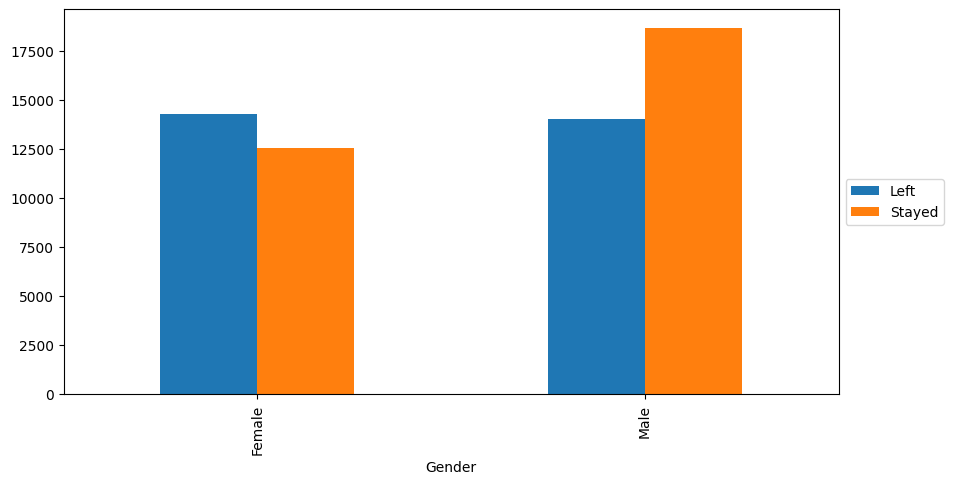

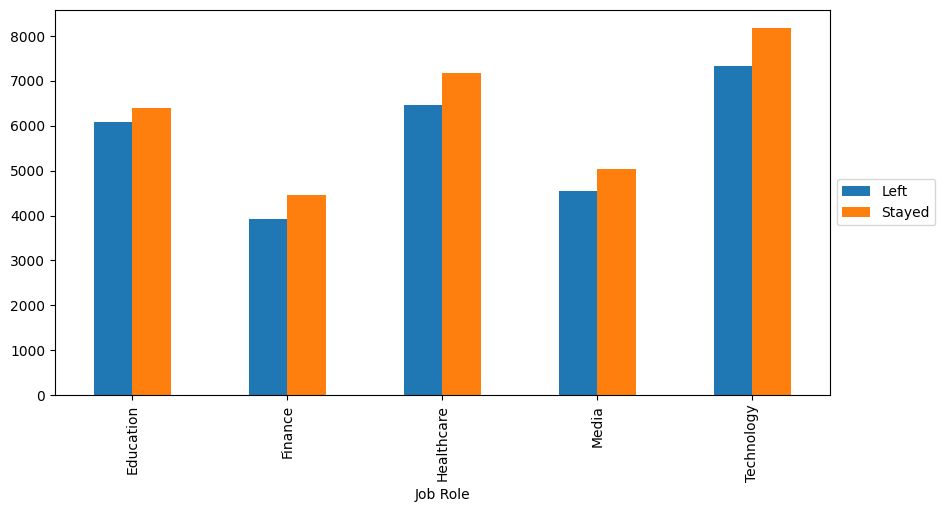

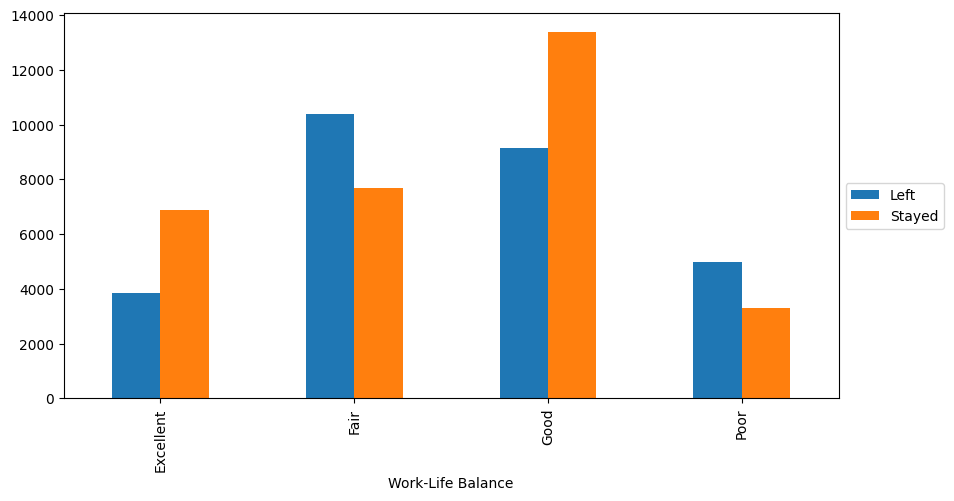

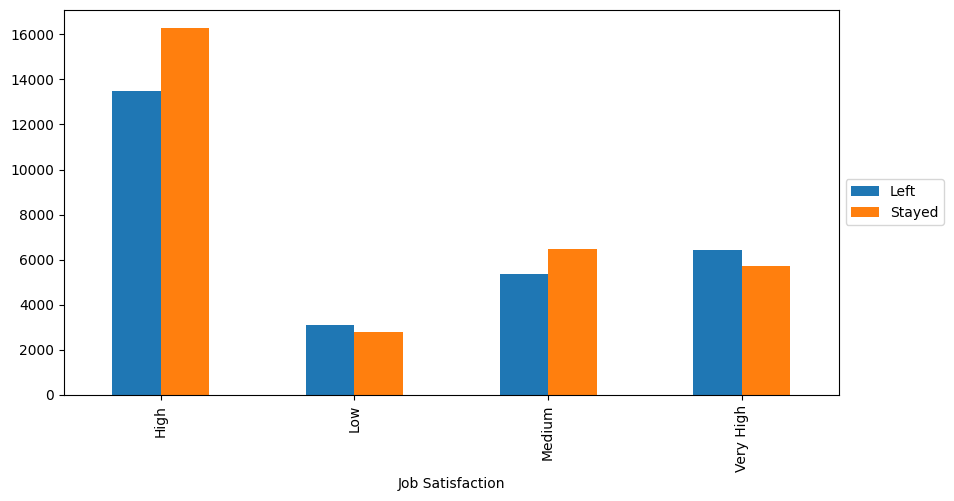

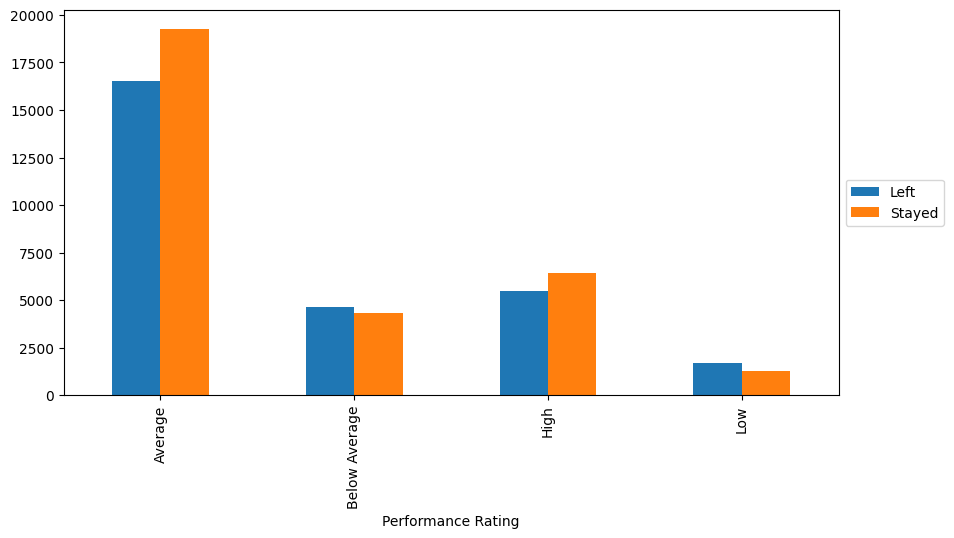

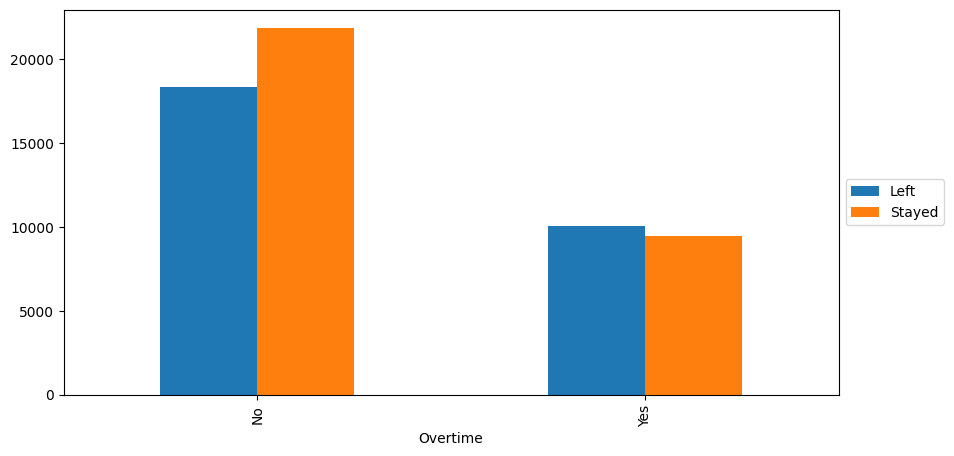

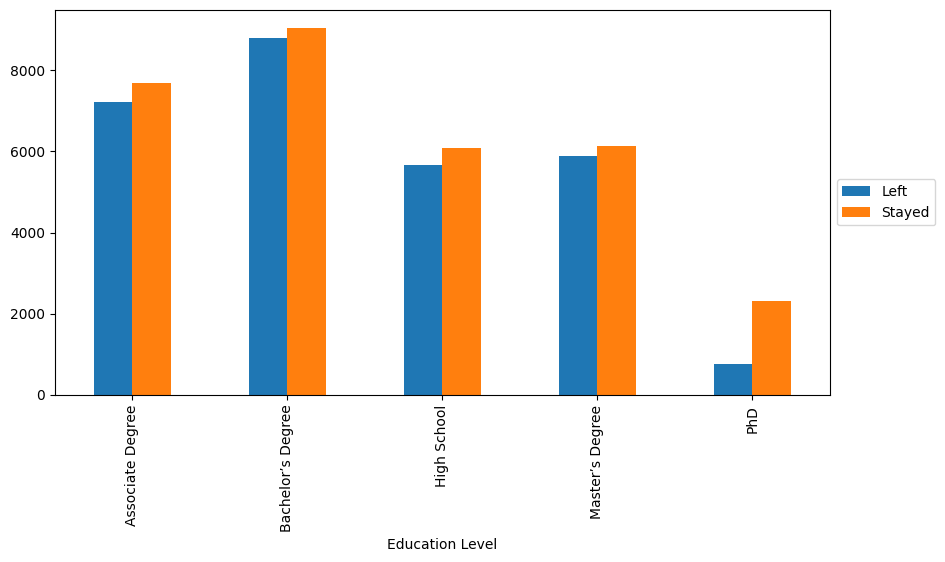

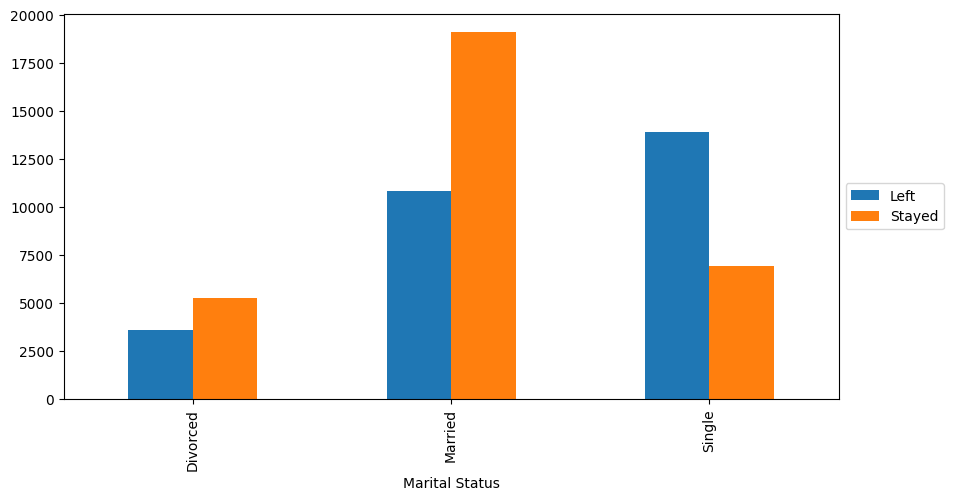

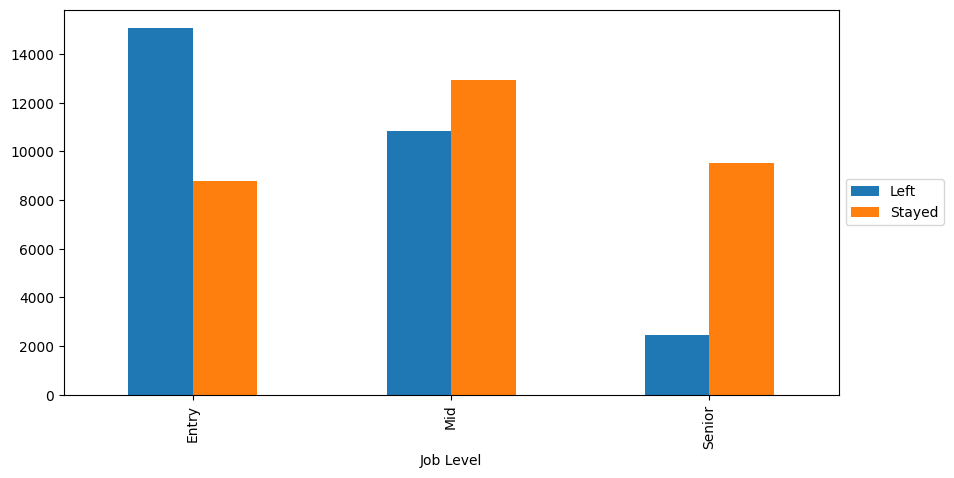

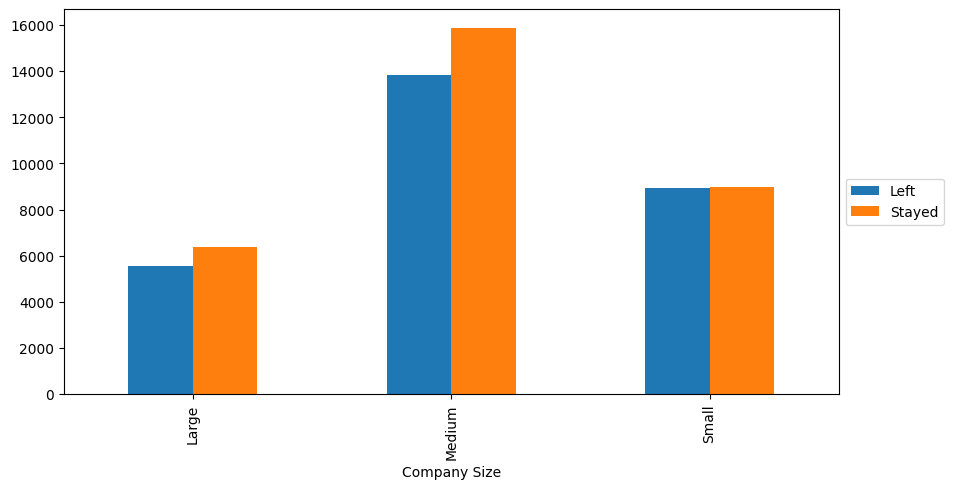

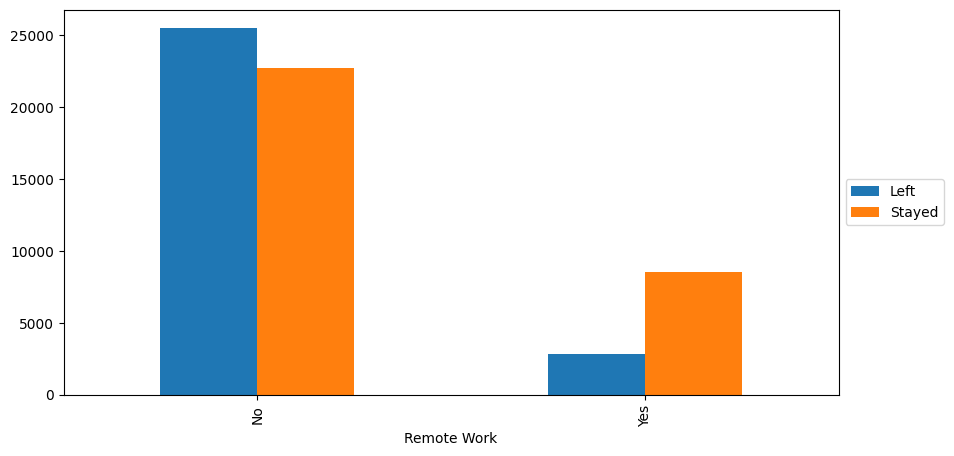

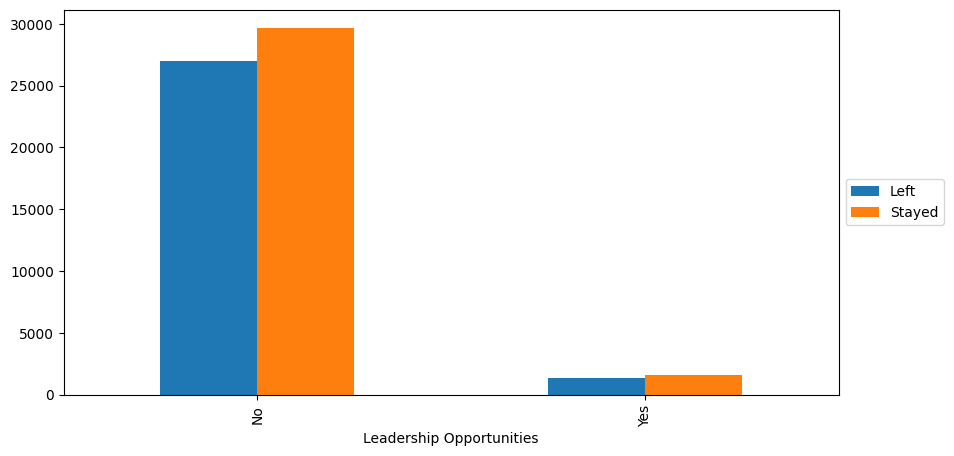

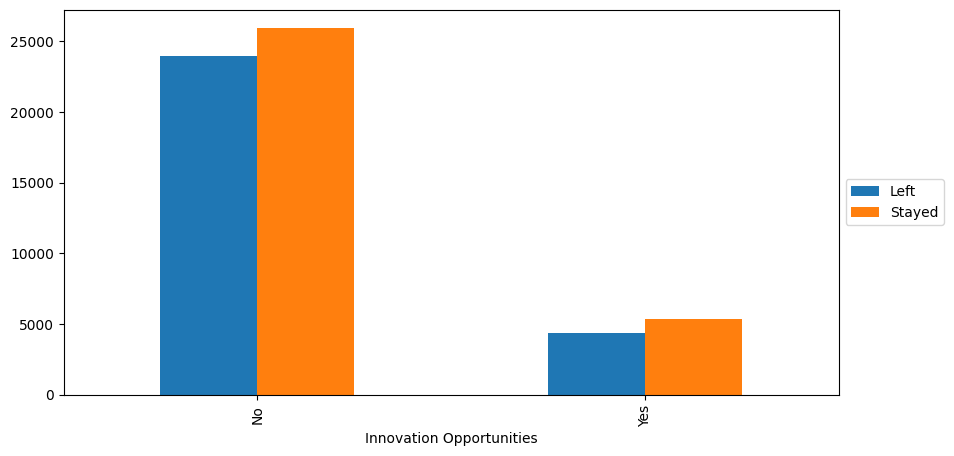

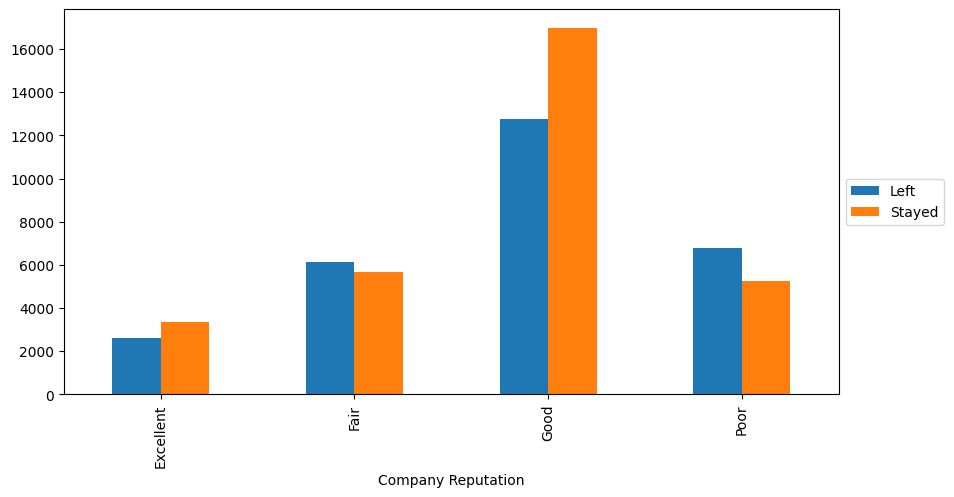

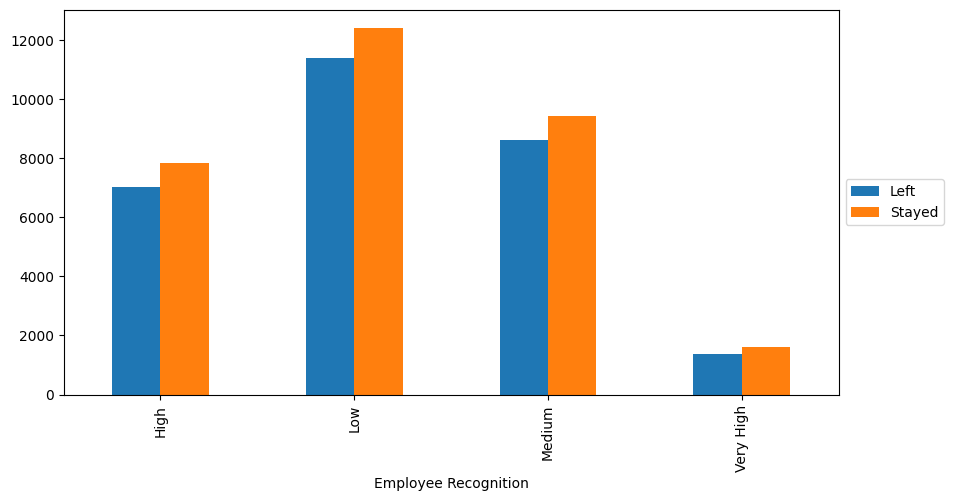

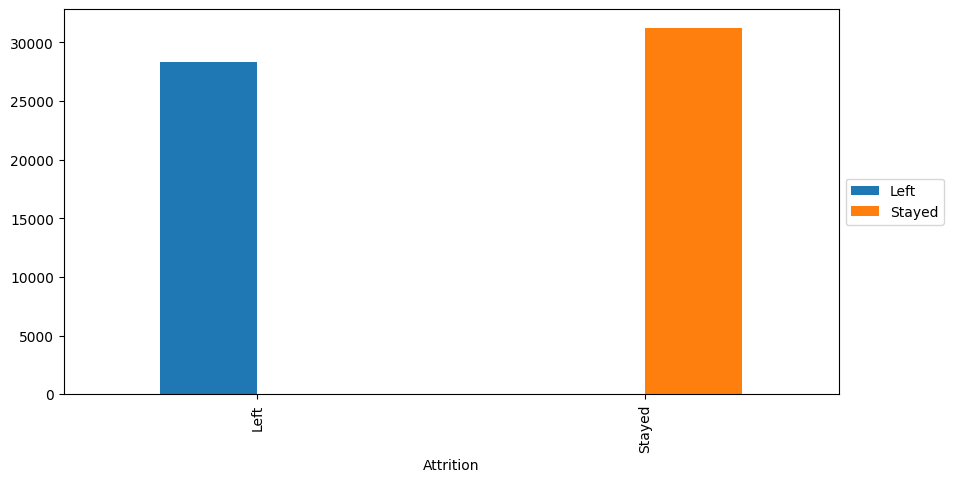

In [84]:
for coluna in col_cat:
    plt.figure(figsize=(10, 5))
    agrupado = treino.groupby([coluna,'Attrition']).size().unstack(fill_value=0)
    agrupado.plot(kind='bar', ax=plt.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

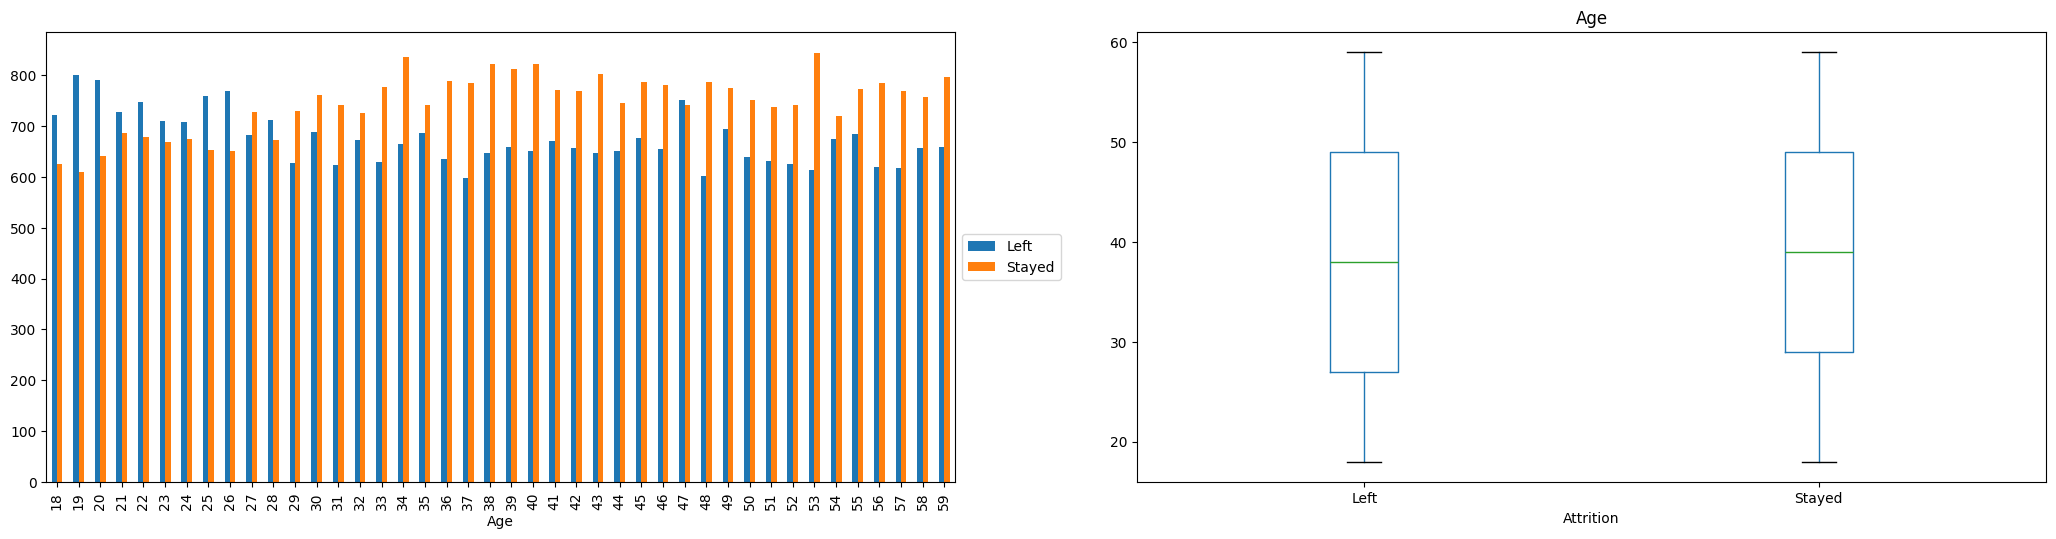

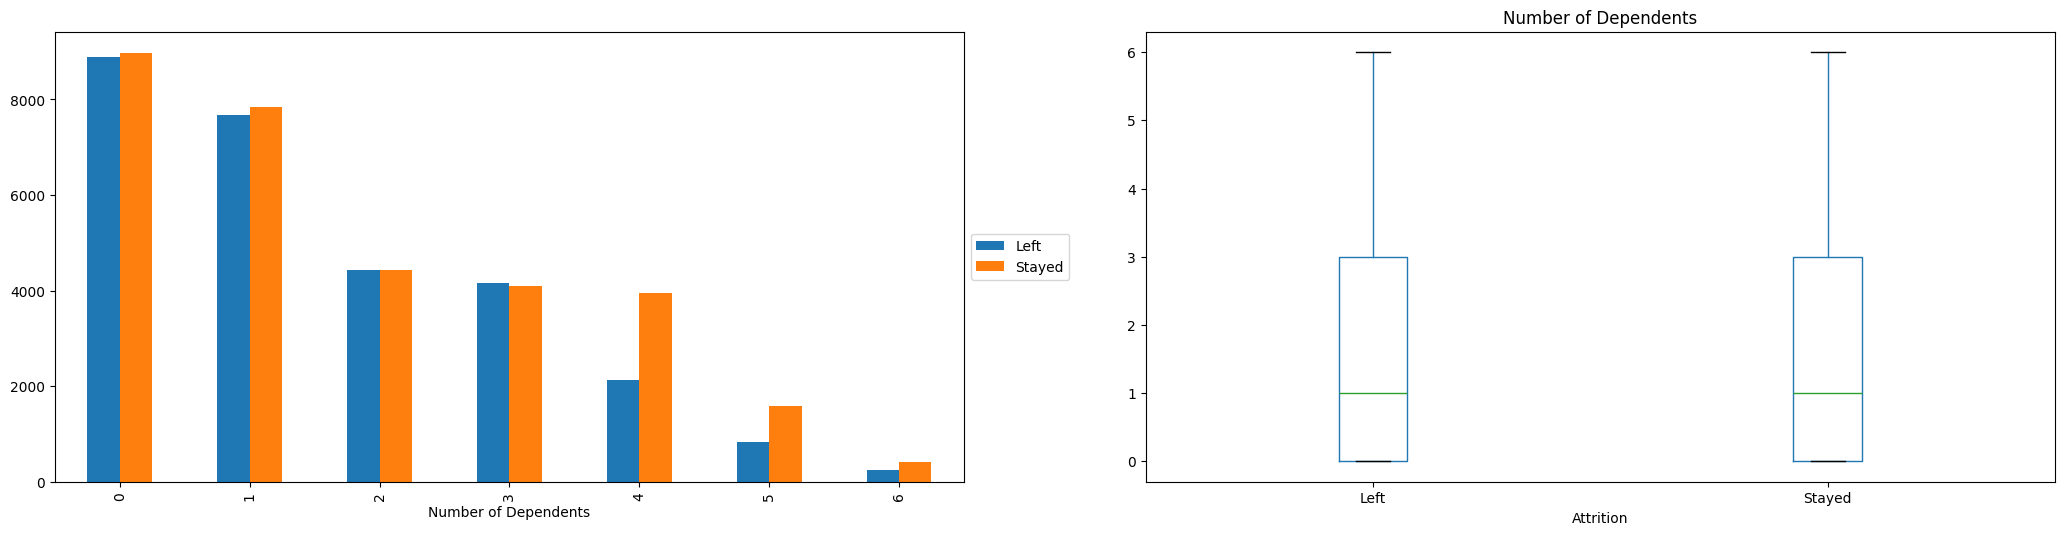

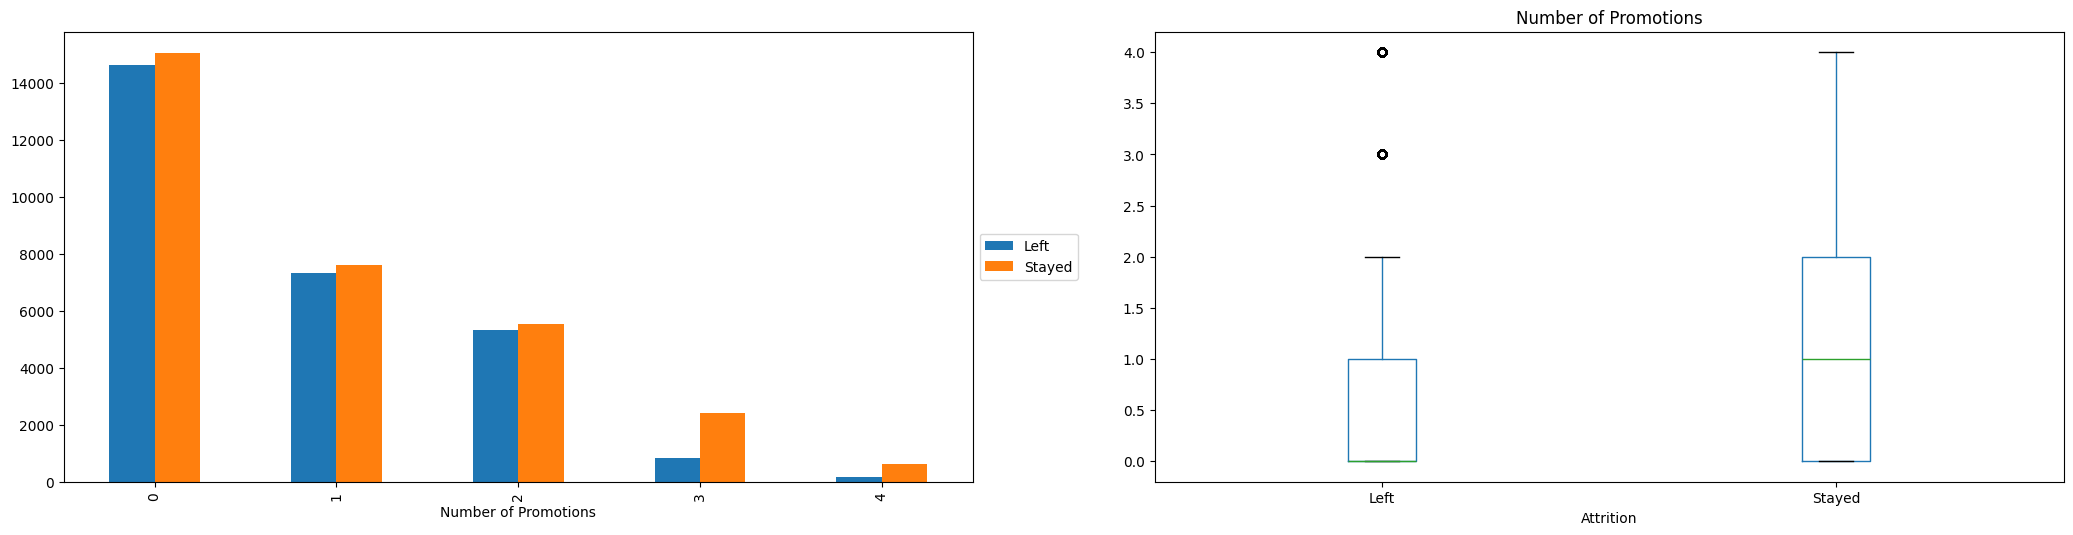

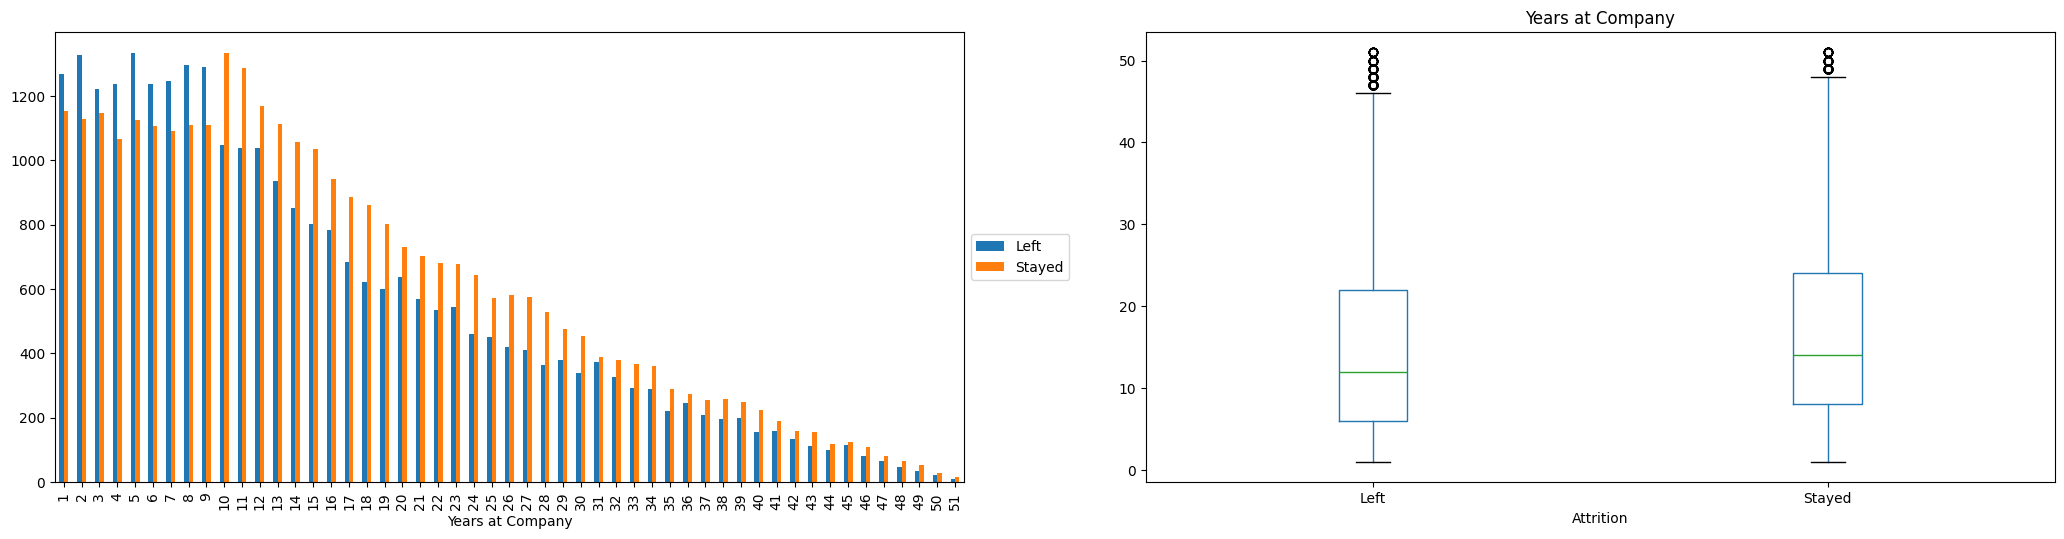

In [85]:

for coluna in col_num.difference(['Employee ID', 'Monthly Income', 'Distance from Home', 'Company Tenure']):
    plt.figure(figsize=(25, 6))

    plt.subplot(1, 2, 1)
    agrupado = treino.groupby([coluna,'Attrition']).size().unstack(fill_value=0)
    agrupado.plot(kind='bar', ax=plt.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.subplot(1, 2, 2)
    plt.subplot(1, 2, 2)
    treino.boxplot(column=coluna, by='Attrition', grid=False, ax=plt.gca())
    plt.suptitle("")

    plt.show()

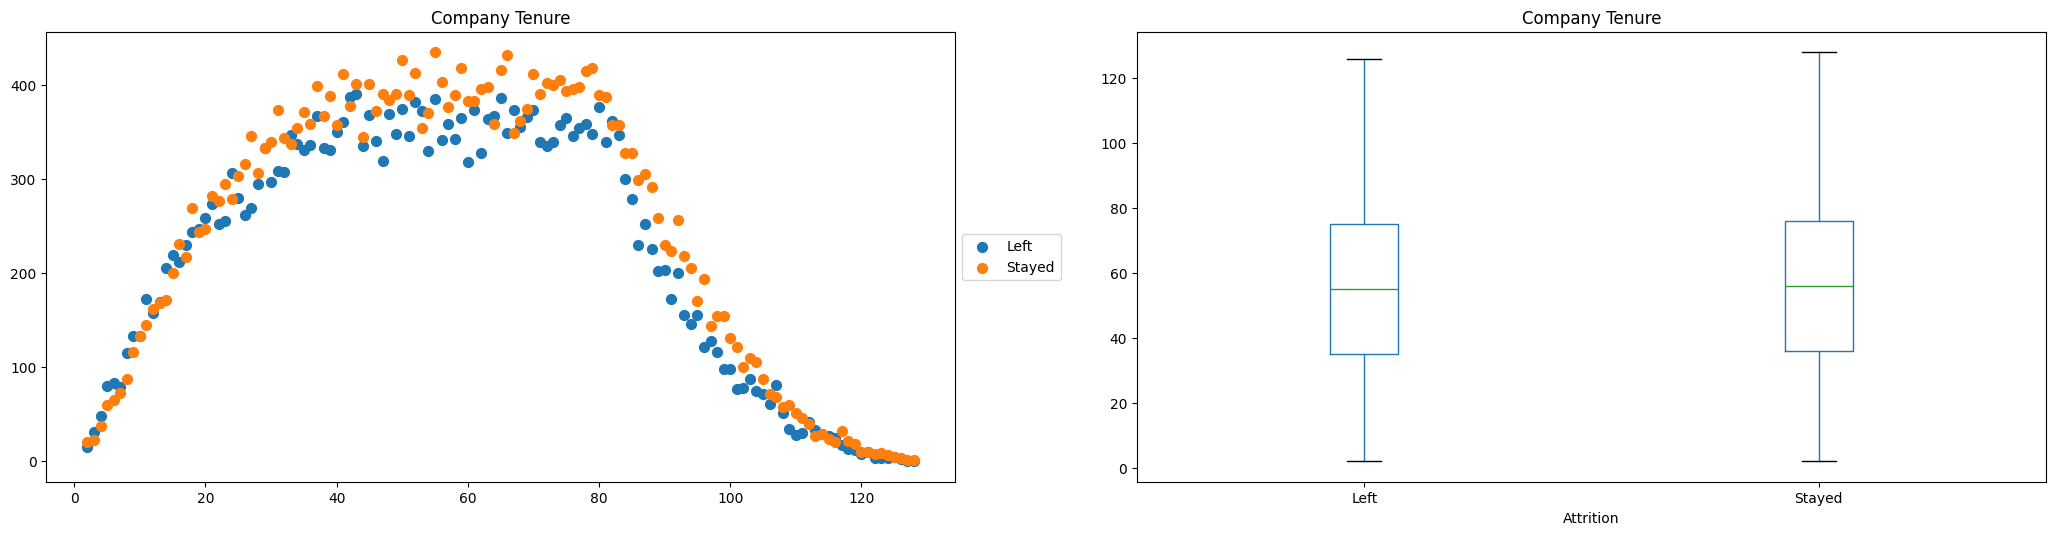

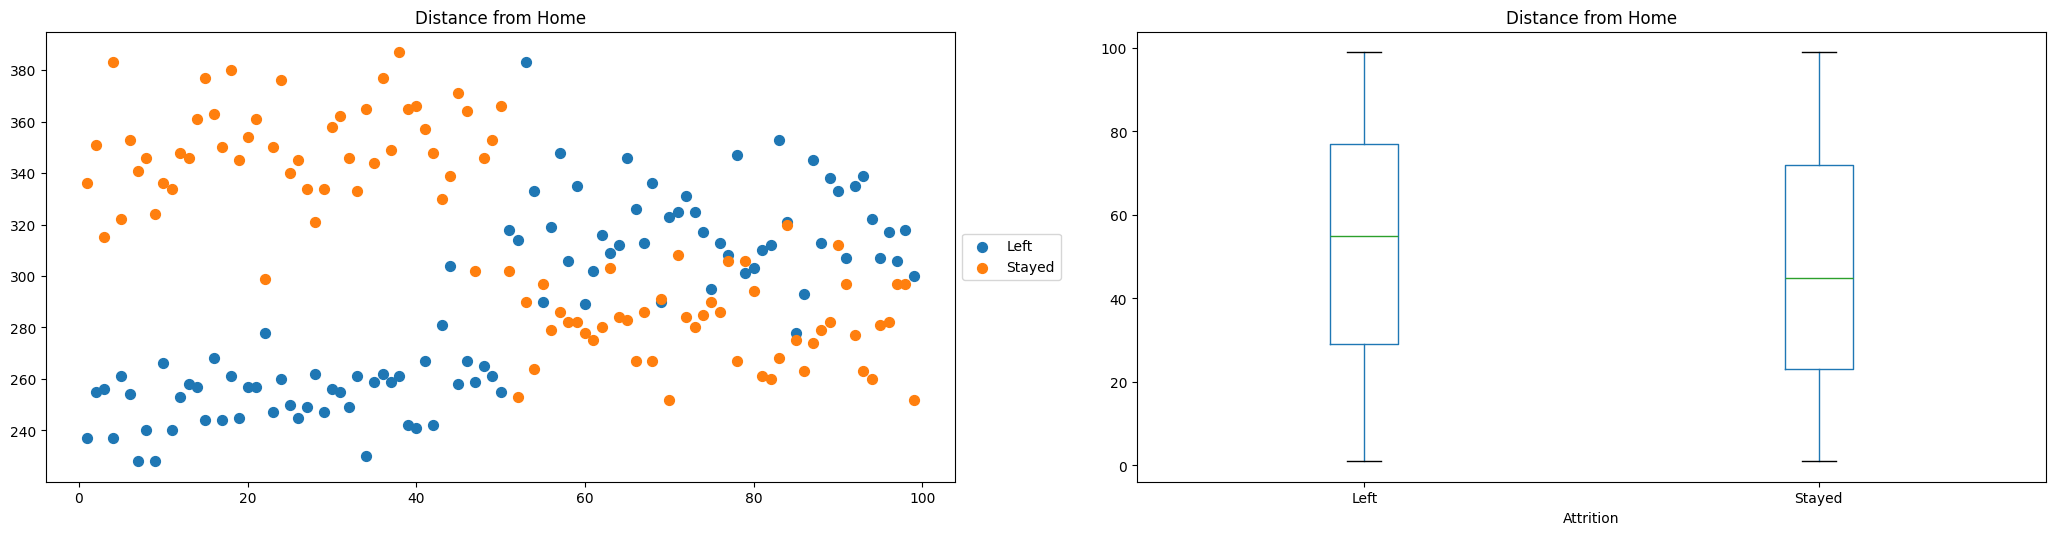

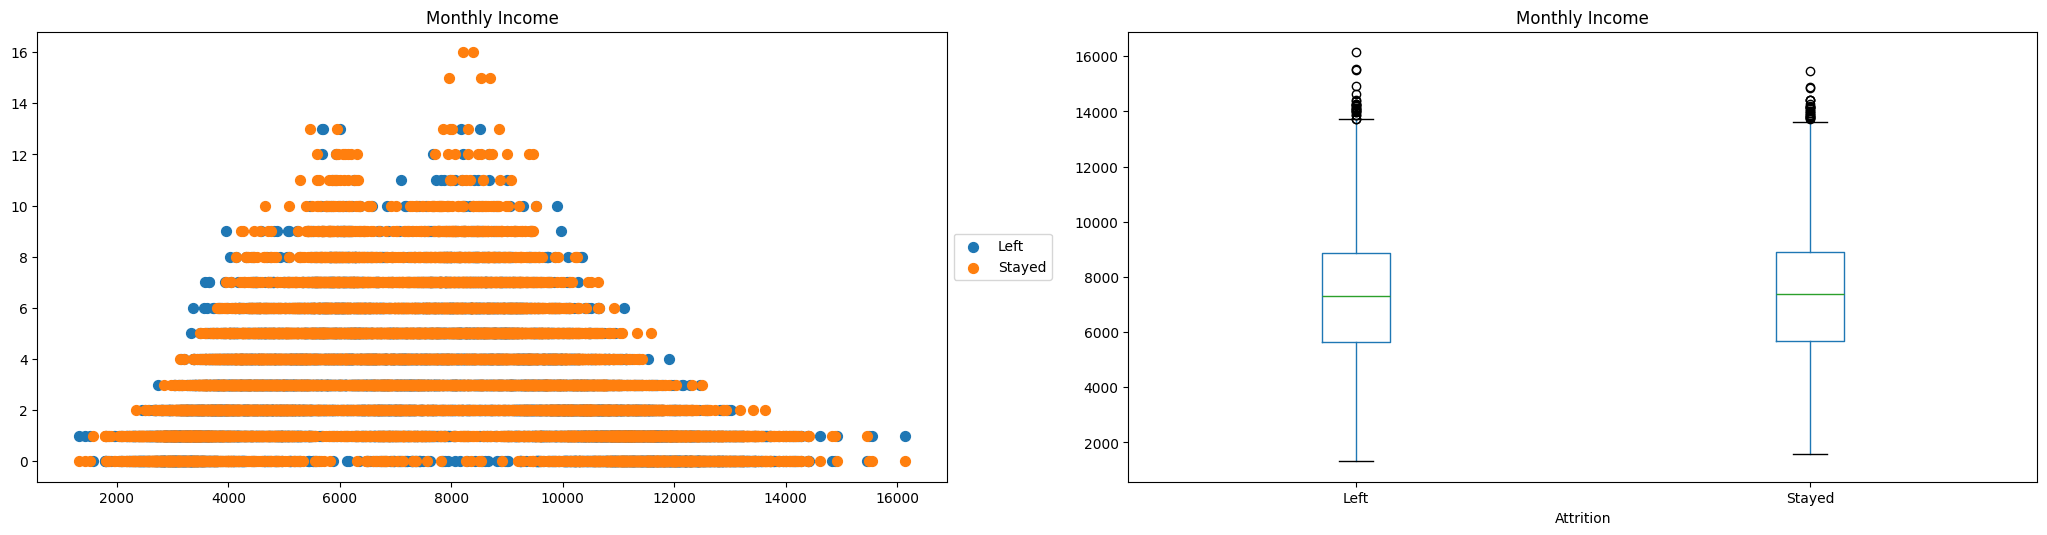

In [86]:
for coluna in col_num.difference(['Employee ID', 'Age', 'Years at Company', 'Number of Promotions', 'Number of Dependents']):
    plt.figure(figsize=(25, 6))

    agrupado = treino.groupby([coluna,'Attrition']).size().unstack(fill_value=0)
    for categoria in agrupado.columns:
        plt.subplot(1, 2, 1)
        plt.scatter(agrupado.index, agrupado[categoria], label=categoria, s=50)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(coluna)

    plt.subplot(1, 2, 2)
    plt.subplot(1, 2, 2)
    treino.boxplot(column=coluna, by='Attrition', grid=False, ax=plt.gca())
    plt.suptitle("")

    plt.show()

In [87]:
outras_colunas = treino[['Monthly Income','Distance from Home','Company Tenure']]

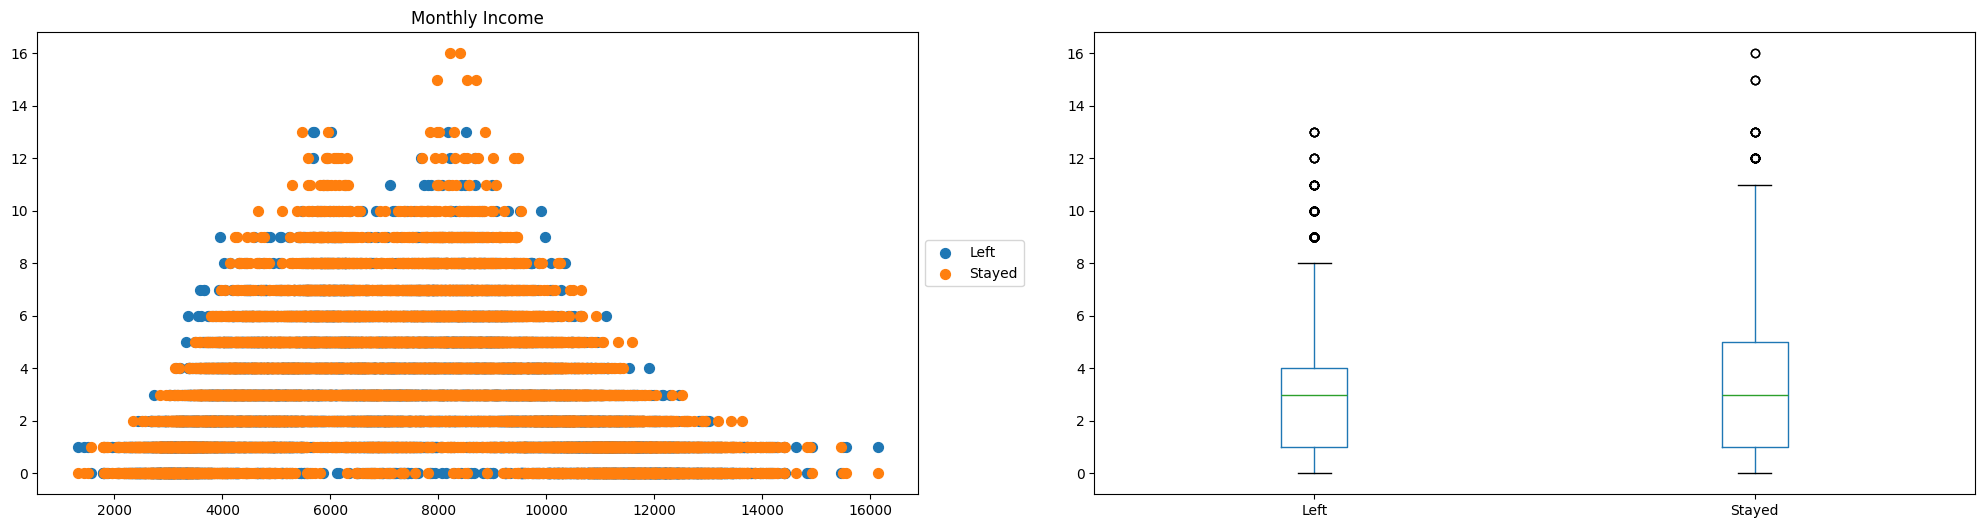

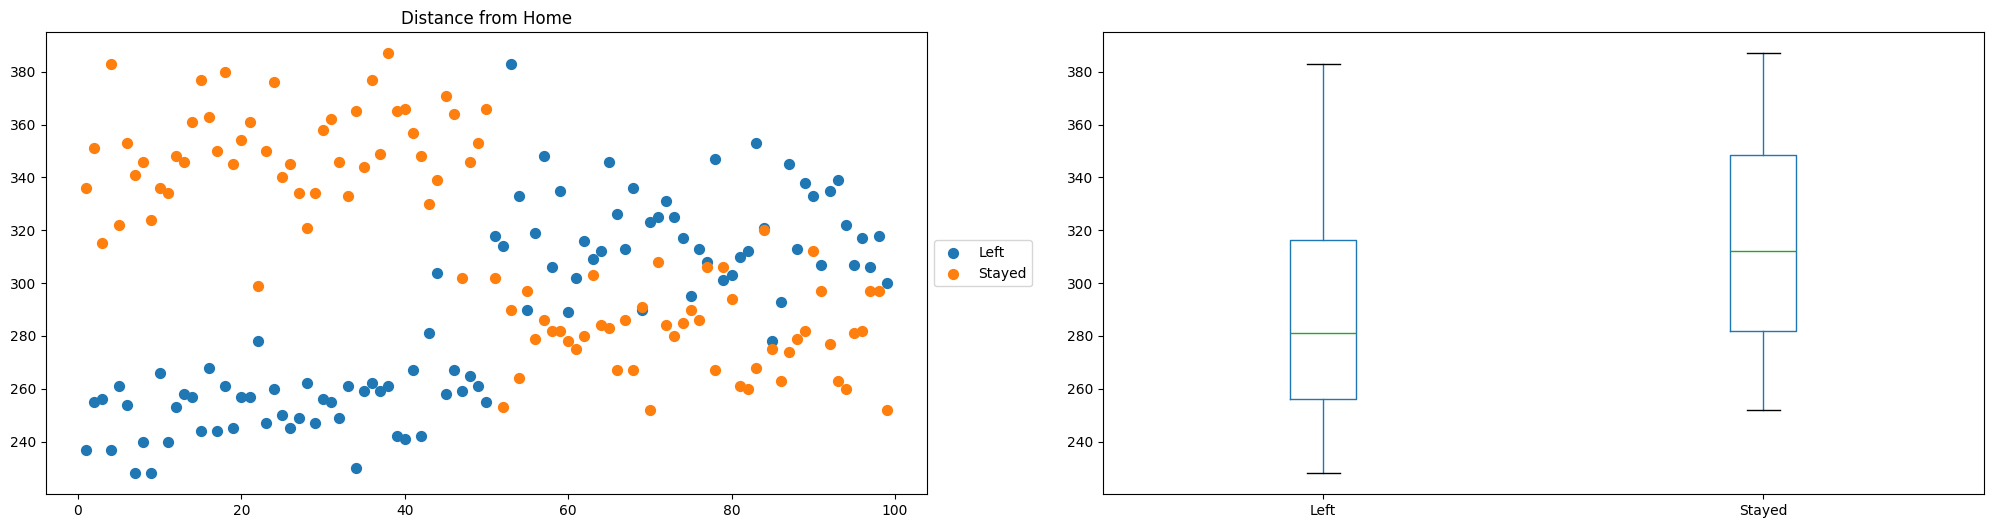

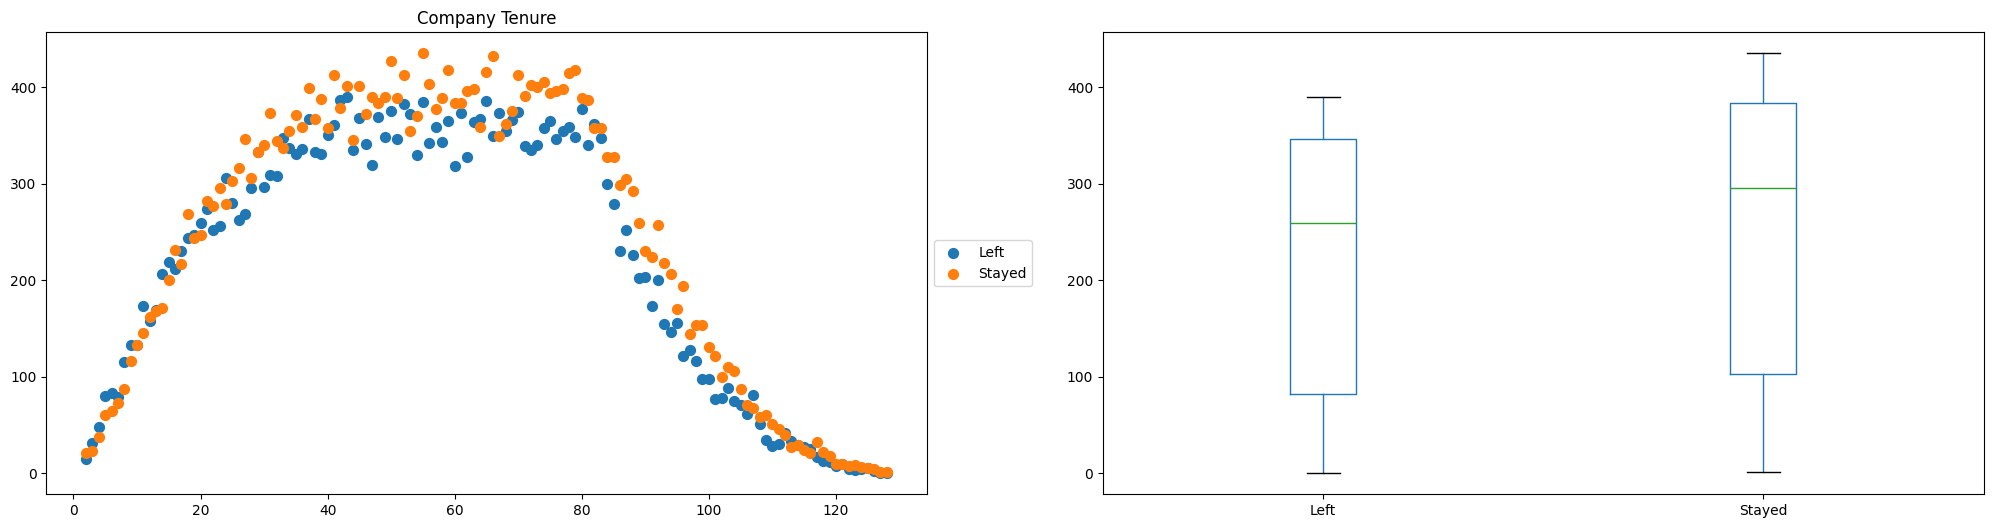

In [88]:
for coluna in outras_colunas:
    
    plt.figure(figsize=(25, 6))

    agrupado = treino.groupby([coluna,'Attrition']).size().unstack(fill_value=0)
    for categoria in agrupado.columns:
        plt.subplot(1, 2, 1)
        plt.scatter(agrupado.index, agrupado[categoria], label=categoria, s=50)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(coluna)

    plt.subplot(1, 2, 2)
    agrupado = treino.groupby([coluna, 'Attrition']).size().unstack(fill_value=0)
    agrupado.boxplot(grid=False)
    plt.suptitle("")

    plt.show()

#### Tratamento das variáveis categóricas e separação da variável target

In [8]:
#aplicar OneHotEncoding separadamente para treino e teste (fit)
encoder = OneHotEncoder(sparse_output=False)
treino_encoder = pd.DataFrame(encoder.fit_transform(treino[col_cat]))
teste_encoder = pd.DataFrame(encoder.transform(teste[col_cat]))

In [9]:
#mudar os nomes das colunas para os nomes OneHotEmcoding
treino_encoder.columns = encoder.get_feature_names_out(col_cat)
teste_encoder.columns = encoder.get_feature_names_out(col_cat)

In [10]:
#nova base de treino com as colunas processadas
treino_processado = treino.drop(columns=col_cat, axis=1).reset_index(drop=True)
treino_processado = pd.concat([treino_processado, treino_encoder], axis=1)

In [11]:
#nova base de teste com as colunas processadas
teste_processado = teste.drop(columns=col_cat, axis=1).reset_index(drop=True)
teste_processado = pd.concat([teste_processado, teste_encoder], axis=1)

In [12]:
#separar target Y do dataset treino e teste
treino_y = treino[['Attrition']]
teste_y = teste[['Attrition']]

#remover target do dataset original
treino_processado.drop(columns=['Attrition_Left','Attrition_Stayed'], inplace=True)
teste_processado.drop(columns=['Attrition_Left','Attrition_Stayed'], inplace=True)

In [13]:
pd.set_option('future.no_silent_downcasting', True)

#transformar a varuável target em binária
treino_y.replace({'Stayed': 0, 'Left': 1}, inplace=True)
treino_y = treino_y.astype(int) 

teste_y.replace({'Stayed': 0, 'Left': 1}, inplace=True)
teste_y = teste_y.astype(int) 

C:\Users\Maria\AppData\Local\Temp\ipykernel_9924\3510248632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino_y.replace({'Stayed': 0, 'Left': 1}, inplace=True)
C:\Users\Maria\AppData\Local\Temp\ipykernel_9924\3510248632.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste_y.replace({'Stayed': 0, 'Left': 1}, inplace=True)


#### calcular correlação

In [95]:
#calcular a correlação para as das variáveis mais influentes para a variável target
correlacoes = pd.DataFrame(treino_processado.corrwith(treino_y.loc[:, 'Attrition'], method='pearson'), columns=['Correlacao'])
correlacoes_filtradas = correlacoes[(correlacoes['Correlacao'] > 0.2) | (correlacoes['Correlacao'] < -0.2)]
correlacoes_filtradas

,Correlacao
Marital Status_Married,-0.229132
Marital Status_Single,0.282988
Job Level_Entry,0.256010
Job Level_Senior,-0.273526
Remote Work_No,0.220447
Remote Work_Yes,-0.220447


#### normalização dos dados

In [96]:
scaler = StandardScaler()

In [98]:
#normalizar treino e teste menos a primeira coluna que é Id
colunas = treino_processado.columns[1:]
treino_processado[colunas] = pd.DataFrame(scaler.fit_transform(treino_processado[colunas]), columns=colunas, index=treino_processado.index)
teste_processado[colunas] = pd.DataFrame(scaler.transform(teste_processado[colunas]), columns=colunas, index=teste_processado.index)
treino_processado.drop(columns='Employee ID', inplace=True)
teste_processado.drop(columns='Employee ID', inplace=True)

#### modelagem

In [104]:
#modelo
modelo_v1 = RandomForestClassifier(random_state=42)

In [105]:
#transformar treino_y em unidimensional
treino_y = treino_y.values.ravel()
teste_y = teste_y.values.ravel()

In [106]:
#treinar o modelo
modelo_v1.fit(treino_processado, treino_y)

RandomForestClassifier(random_state=42)

In [107]:
y_pred = modelo_v1.predict(teste_processado)

In [108]:
#avalição do modelo
acuracia = accuracy_score(teste_y,y_pred)
class_rep = classification_report(teste_y,y_pred)

In [109]:
acuracia

0.7456375838926175

In [110]:
print(class_rep)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      7868
           1       0.74      0.72      0.73      7032

    accuracy                           0.75     14900
   macro avg       0.74      0.74      0.74     14900
weighted avg       0.75      0.75      0.75     14900



#### validação cruzada

In [111]:
#criar novo modelo para validação cruzada
modelo_vc = RandomForestClassifier(random_state=42)

In [112]:
#validação crizada com 5 folds
scores_vc = cross_val_score(modelo_vc, treino_processado, treino_y, cv=5)

In [113]:
scores_vc

array([0.74899329, 0.74152685, 0.74471477, 0.74410605, 0.74293145])

#### otimização de hiperparâmetros

In [114]:
# hiperparâmetros para serem otimizados
param_grid = {
    'n_estimators': [50, 100, 200],     
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 4, 6],   
    'min_samples_leaf': [1, 2, 4]     
}

In [115]:
#modelo para otimização 
modelo_otm = RandomForestClassifier(random_state=42)

In [116]:
#configurar a grade com validação cruzada
grid_search = GridSearchCV(modelo_otm, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)

In [117]:
#otimização no conjunto de treino
grid_search.fit(treino_processado, treino_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [121]:
#verificar melhores parâmetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'max_depth': 20,
  'min_samples_leaf': 2,
  'min_samples_split': 6,
  'n_estimators': 200},
 np.float64(0.750142591406986))

#### versão final do modelo

In [122]:
#hiperparametros do modelo final
modelo_final = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                                          max_depth = best_params['max_depth'],
                                          min_samples_split = best_params['min_samples_split'],
                                          min_samples_leaf = best_params['min_samples_leaf'],
                                          random_state = 42)

In [123]:
#treinar o modelo final
modelo_final.fit(treino_processado, treino_y)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=200, random_state=42)

In [124]:
#previsão do modelo final
y_pred_final = modelo_final.predict(teste_processado)

In [125]:
#avaliação do modelo final
final_acuracia = accuracy_score(teste_y, y_pred_final)
final_class_rep = classification_report(teste_y, y_pred_final)

In [126]:
final_acuracia

0.7526845637583892

In [127]:
print(final_class_rep)

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      7868
           1       0.74      0.73      0.74      7032

    accuracy                           0.75     14900
   macro avg       0.75      0.75      0.75     14900
weighted avg       0.75      0.75      0.75     14900



#### dump do modelo final

In [128]:
joblib.dump(modelo_final, r"C:\Users\Maria\Desktop\projeto_floresta_aleatoria\Analise-De-Dados-2025\Random-forest-Employee-attrition\modelo_floresta_al.pkl")

['C:\\Users\\Maria\\Desktop\\projeto_floresta_aleatoria\\Analise-De-Dados-2025\\Random-forest-Employee-attrition\\modelo_floresta_al.pkl']

In [129]:
joblib.dump(scaler, r"C:\Users\Maria\Desktop\projeto_floresta_aleatoria\Analise-De-Dados-2025\Random-forest-Employee-attrition\scaler_floresta_al.pkl")

['C:\\Users\\Maria\\Desktop\\projeto_floresta_aleatoria\\Analise-De-Dados-2025\\Random-forest-Employee-attrition\\scaler_floresta_al.pkl']

In [130]:
joblib.dump(encoder, r"C:\Users\Maria\Desktop\projeto_floresta_aleatoria\Analise-De-Dados-2025\Random-forest-Employee-attrition\encoder_floresta_al.pkl")

['C:\\Users\\Maria\\Desktop\\projeto_floresta_aleatoria\\Analise-De-Dados-2025\\Random-forest-Employee-attrition\\encoder_floresta_al.pkl']